### Uploading to S3

In [1]:
from utils import *

import boto3
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()

prefix='dengai'

train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

train_path  = sagemaker_session.upload_data(train_json, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_json,  bucket=bucket, key_prefix=test_prefix)

In [2]:
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.estimator import Estimator

image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar') 
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

freq='W'
context_length=260 # max of our prediction windows

hyperparameters = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(context_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

estimator.set_hyperparameters(**hyperparameters)


### Creating training job

In [7]:
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.estimator import Estimator

image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar') 
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

freq='W'
context_length=260 # max of our prediction windows

hyperparameters = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(context_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

estimator.set_hyperparameters(**hyperparameters)


In [ ]:
data_channels = {
    "train": train_path,
#    "test": test_path
}

estimator.fit(inputs=data_channels)

### If we want to skip training and reuse a previously trained model

In [3]:
sagemaker_session.list_s3_files(bucket, prefix)

['dengai/batch-inference/test.json.out',
 'dengai/output/forecasting-deepar-2020-04-02-20-36-06-182/output/model.tar.gz',
 'dengai/test/test.json',
 'dengai/train/test.json',
 'dengai/train/train.json',
 'dengai/train/train_out.json']

In [4]:
from sagemaker.model import Model

model_file = 'dengai/output/forecasting-deepar-2020-04-02-20-36-06-182/output/model.tar.gz'
model_s3_path = f's3://{bucket}/{model_file}'

model = Model(model_data=model_s3_path,
              image=image_name,
             role=role)

## Testing our model

In [5]:
s3_batch_output_path = 's3://{}/{}/batch-inference'.format(bucket, prefix)

# uncomment to  use freshly trained model
# model = estimator

transformer = model.transformer(instance_count=1,
                                instance_type='ml.m4.xlarge',
                                strategy='SingleRecord',
                                assemble_with='Line',
                                output_path=s3_batch_output_path)


transformer.transform(data=test_path, data_type='S3Prefix', content_type=None, split_type='Line')
transformer.wait()

........................
.Arguments: serve
No handlers could be found for logger "root"
[04/07/2020 10:58:07 INFO 140591537907520] Estimated memory required per model 125MB.
[04/07/2020 10:58:07 INFO 140591537907520] Estimated available memory 14774MB.
[04/07/2020 10:58:07 INFO 140591537907520] Estimated maximum number of workers for the available memory is 117.
[04/07/2020 10:58:07 INFO 140591537907520] Using 4 workers
[04/07/2020 10:58:07 INFO 140591537907520] loading entry points
[04/07/2020 10:58:07 INFO 140591537907520] Prediction endpoint operating in batch mode
[04/07/2020 10:58:07 INFO 140591537907520] loaded request iterator application/jsonlines
[04/07/2020 10:58:07 INFO 140591537907520] loaded response encoder application/jsonlines
[04/07/2020 10:58:07 INFO 140591537907520] loaded model class model
[04/07/2020 10:58:07 WARNING 140591537907520] Requesting context without setting the requested num of gpus. Using 'auto'
[04/07/2020 10:58:07 INFO 140591537907520] nvidia-smi took

In [9]:
sagemaker_session.list_s3_files(bucket, prefix)

['dengai/batch-inference/test.json.out',
 'dengai/output/forecasting-deepar-2020-04-02-20-36-06-182/output/model.tar.gz',
 'dengai/test/test.json',
 'dengai/train/test.json',
 'dengai/train/train.json',
 'dengai/train/train_out.json']

In [7]:
predictions = sagemaker_session.read_s3_file(bucket, 'dengai/batch-inference/test.json.out')

In [21]:
# helper function to decode JSON prediction
def unjson_prediction(prediction):
    '''Accepts a JSON prediction and returns a list of quantiles for prediction.
    '''
    prediction_data = json.loads(prediction)
    predictions_quantiles = pd.DataFrame(json.loads(predictions)['quantiles'])
    return predictions_quantiles

In [24]:
# get quantiles/predictions
prediction_list = unjson_prediction(predictions)
prediction_list.head()

,0.9,0.8,0.1,0.3,0.2,0.5,0.4,0.7,0.6
0,39.031010,17.814156,-53.983021,-25.475071,-35.061924,-9.170671,-18.057896,5.807765,-0.841711
1,40.637886,22.125973,-47.326069,-26.382660,-34.628517,-9.080470,-14.388029,10.184536,-1.517869
2,44.574913,26.816200,-60.027771,-17.561552,-26.947401,0.981100,-6.953906,12.862263,7.243910
3,64.973145,46.729702,-57.303787,-18.366737,-39.520645,10.361946,0.989868,25.941263,19.319803
4,67.944481,43.606434,-65.740692,-9.202693,-23.860844,11.258343,0.563121,29.077660,19.214878


In [29]:
import matplotlib.pyplot as plt

# display the prediction median against the actual data
def display_quantiles(prediction, target_ts=None):
    plt.figure(figsize=(12,6))
    # get the target month of data
    if target_ts is not None:
        target = target_ts[k][-prediction_length:]
        plt.plot(range(len(target)), target, label='target')
    # get the quantile values at 10 and 90%
    p10 = prediction['0.1']
    p90 = prediction['0.9']
    # fill the 80% confidence interval
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    # plot the median prediction line
    prediction['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

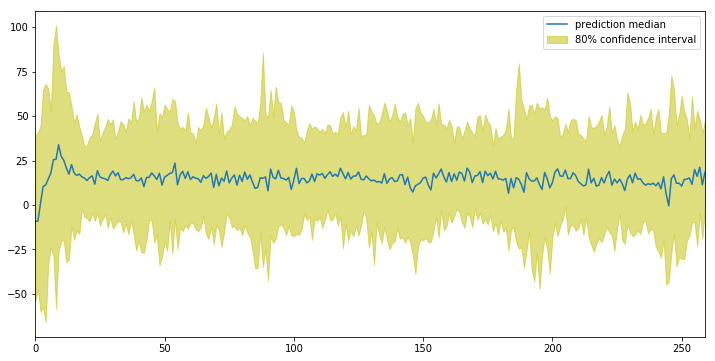

In [30]:
display_quantiles(prediction_list, None)